# Retinal blood vessels detection
#### by Michał Pawlicki & Agnieszka Grzymska

## Image processing algorithm

### 1. Image preprocessing - histogram equalization

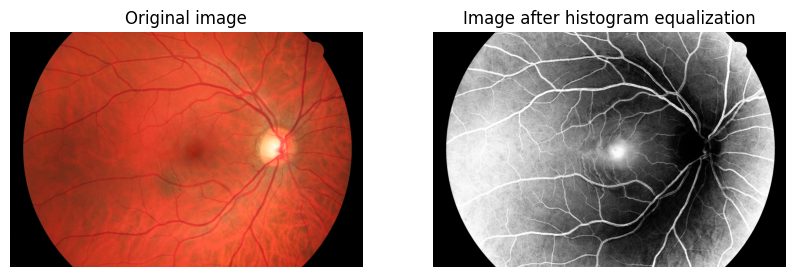

In [1]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage.filters import hessian, frangi

def get_green_channel(img):
    _, green_img, _ = cv.split(img)
    green_img = invert_colors(green_img)
    return green_img

def invert_colors(img):
    new_image = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for x, row in enumerate(img):
        for y, _ in enumerate(row):
            new_image[x][y] = abs(255 - img[x][y])
    return new_image

images_paths = os.listdir('input/healthy/images')
images = []

for path in images_paths[:1]:
    initial_img = cv.imread("input/healthy/images/" + path, cv.IMREAD_COLOR)
    assert initial_img is not None, "file could not be read, check with os.path.exists()"
    initial_img = cv.cvtColor(initial_img, cv.COLOR_BGR2RGB)
    img_mask = cv.imread("input/healthy/masks/" + path[:-4] + "_mask.tif", cv.IMREAD_GRAYSCALE)
    img = get_green_channel(initial_img)
    img = cv.bitwise_and(img, img, mask=img_mask)
    equ = cv.equalizeHist(img)
    images.append(equ)

    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(initial_img)
axs[0].set_title('Original image')
axs[0].axis('off')
axs[1].imshow(cv.cvtColor(equ, cv.COLOR_BGR2RGB))
axs[1].set_title('Image after histogram equalization')
axs[1].axis('off')

plt.show()

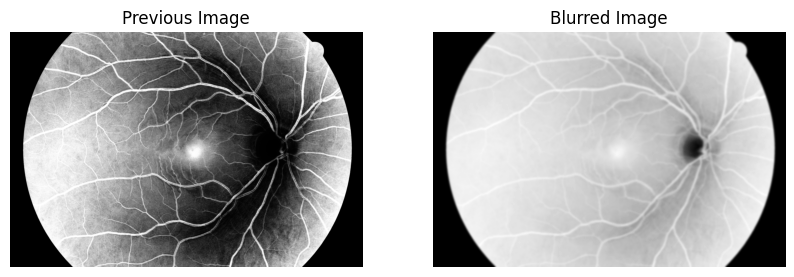

In [2]:
blured = cv.GaussianBlur(img, (51,51), 0)

# Display the original image and the blurred image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(equ, cmap='gray')
axs[0].set_title('Previous Image')
axs[0].axis('off')
axs[1].imshow(blured, cmap='gray')
axs[1].set_title('Blurred Image')
axs[1].axis('off')

plt.show()

### 2. Proper processing - Hessian filter

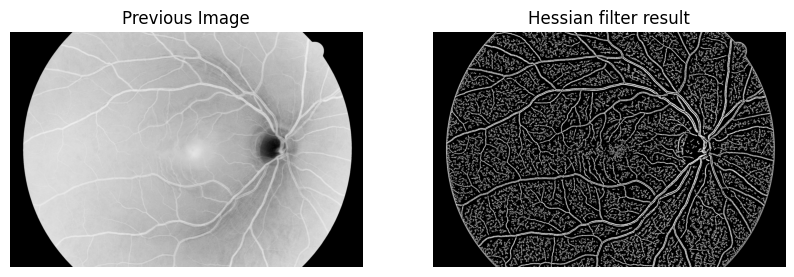

In [3]:
hes_img = hessian(img)
hes_img = cv.bitwise_and(hes_img, hes_img, mask=img_mask)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Previous Image')
axs[0].axis('off')
axs[1].imshow(hes_img, cmap='gray')
axs[1].set_title('Hessian filter result')
axs[1].axis('off')

plt.show()

### 3. Final image processing

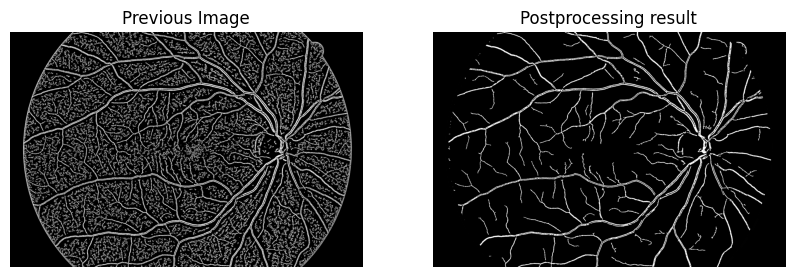

In [50]:
def noise_removing(img, min_size = 600):
    nb_components, output, stats, centroids = cv.connectedComponentsWithStats(img, connectivity=8)
    sizes = stats[1:, -1]
    clear_img = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for i in range(0, nb_components - 1):
        if sizes[i] >= min_size:
            clear_img[output == i + 1] = 255
    return clear_img

def retina_circle_removing(img, base_offset=2000):
    no_retina_img = img.copy()
    circle = np.zeros(img.shape, np.uint8)
    offset = 0
    detections = []
    while True:
        detections = cv.HoughCircles(no_retina_img, cv.HOUGH_GRADIENT, 1.5, base_offset + offset)
        if detections is None:
            return no_retina_img
        if len(detections[0]) == 1:
            break
        offset += 100
    for (x, y, r) in detections[0]:
        cv.circle(circle, (int(x), int(y)), int(r), (255, 255, 255), 40)
    no_retina_img = no_retina_img - circle
    return no_retina_img


filtered_img = cv.bilateralFilter(np.uint8(hes_img),8,75,75)
clear_img = noise_removing(filtered_img)
clear_img = retina_circle_removing(clear_img)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(hes_img, cmap='gray')
axs[0].set_title('Previous Image')
axs[0].axis('off')
axs[1].imshow(clear_img, cmap='gray')
axs[1].set_title('Postprocessing result')
axs[1].axis('off')

plt.show()

### 4. Final results

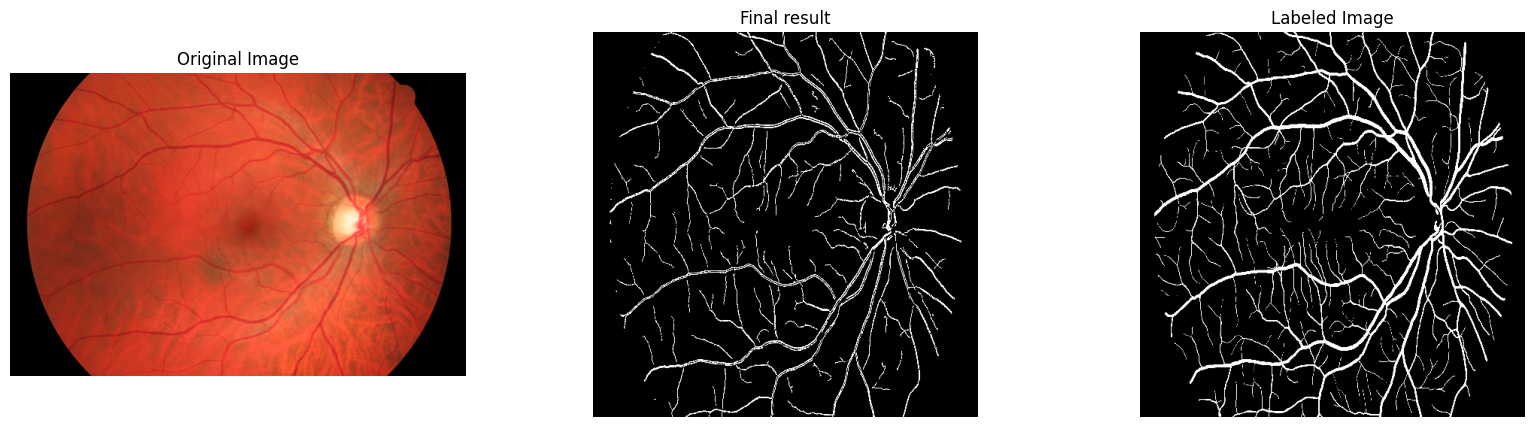

In [51]:
from confusion import ConfusionMatrix

labeled_image = cv.imread("input/healthy/labeled_images/" + path[:-3] + "tif", cv.IMREAD_GRAYSCALE)
labeled_image = cv.resize(labeled_image, dsize=(512, 512), interpolation=cv.INTER_CUBIC)
clear_img = cv.resize(clear_img, dsize=(512, 512), interpolation=cv.INTER_CUBIC)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(initial_img)
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(clear_img, cmap='gray')
axs[1].set_title('Final result')
axs[1].axis('off')
axs[2].imshow(labeled_image, cmap='gray')
axs[2].set_title('Labeled Image')
axs[2].axis('off')

labeled_image = labeled_image /255

labeled_image = labeled_image > 0.5
labeled_image = labeled_image.astype(np.uint8)
labeled_image = labeled_image.reshape(-1)

clear_img = clear_img /255

clear_img = clear_img > 0.5
clear_img = clear_img.astype(np.uint8)
clear_img = clear_img.reshape(-1)


cm = ConfusionMatrix(labeled_image, clear_img)
plt.show()
print(cm)

## UNET

### Train and Validation step definitions

In [10]:
import torch.nn as nn
import torch

def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: nn.Module,
               accuracy_fn,
               device: torch.device):
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy_fn(y_pred, y)

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"\nTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")


def valid_step(model, loader, loss_fn, accuracy_fn, device):
    valid_loss, valid_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            valid_loss += loss.item()
            valid_acc += accuracy_fn(y_pred, y)

    valid_loss /= len(loader)
    valid_acc /= len(loader)
    print(f"Valid loss: {valid_loss:.5f} | Valid accuracy: {valid_acc:.2f}")

    return valid_loss

### Dataset definition

In [11]:
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

class ChasedDataset(Dataset):
    def __init__(self, images_path, answers_path):
        self.images_path = images_path
        self.answers_path = answers_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        img = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        img = img / 255.0
        img = np.transpose(img, (2, 0, 1))
        img = torch.from_numpy(img.astype(np.float32))

        ans = cv2.imread(self.answers_path[index], cv2.IMREAD_GRAYSCALE)
        ans = cv2.resize(ans, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        ans = ans / 255.0
        ans = ans[np.newaxis, ...]
        ans = torch.from_numpy(ans.astype(np.float32))

        return img, ans

    def __len__(self):
        return self.n_samples

### Train Phase

In [12]:
import gc
import os
from glob import glob
import random
from torch.utils.data import DataLoader
from model import BuildUnet
from utils import calculate_accuracy
from tqdm import tqdm
from loss import DiceBCELoss

H, W = 512, 512
BATCH_SIZE = 1
EPOCHS = 50
LR = 1e-4
CHECKPOINT = r"./output/models/unet_checkpoint.pth"
DATA_PATH = r"./input"
SEED = 42



gc.collect()
torch.cuda.empty_cache()

random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_x = sorted(glob(f"{DATA_PATH}/Train/Images/*"))
train_y = sorted(glob(f"{DATA_PATH}/Train/Masks/*"))

valid_x = sorted(glob(f"{DATA_PATH}/Validation/Images/*"))
valid_y = sorted(glob(f"{DATA_PATH}/Validation/Masks/*"))

print(f"Dataset Size:\nTrain: {len(train_x)} - Validation: {len(valid_x)}")

train_dataset = ChasedDataset(train_x, train_y)
valid_dataset = ChasedDataset(valid_x, valid_y)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

device = torch.device('cuda')
model = BuildUnet()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()


best_valid_loss = float("inf")
for epoch in tqdm(range(EPOCHS)):

    train_step(model, train_loader, optimizer, loss_fn, calculate_accuracy, device)
    valid_loss = valid_step(model, valid_loader, loss_fn, calculate_accuracy, device)

    if valid_loss < best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {CHECKPOINT}"
        print(data_str)

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), CHECKPOINT)

Dataset Size:
Train: 30 - Validation: 10


  0%|          | 0/50 [00:00<?, ?it/s]


Train loss: 1.23655 | Train accuracy: 0.94
Valid loss: 1.35297 | Valid accuracy: 0.92
Valid loss improved from inf to 1.3530. Saving checkpoint: ./output/models/unet_checkpoint.pth


  2%|▏         | 1/50 [00:14<11:42, 14.33s/it]


Train loss: 1.05051 | Train accuracy: 0.95
Valid loss: 1.08168 | Valid accuracy: 0.95
Valid loss improved from 1.3530 to 1.0817. Saving checkpoint: ./output/models/unet_checkpoint.pth


  4%|▍         | 2/50 [00:24<09:25, 11.78s/it]


Train loss: 0.98326 | Train accuracy: 0.96
Valid loss: 1.00973 | Valid accuracy: 0.95
Valid loss improved from 1.0817 to 1.0097. Saving checkpoint: ./output/models/unet_checkpoint.pth


  6%|▌         | 3/50 [00:34<08:43, 11.13s/it]


Train loss: 0.93778 | Train accuracy: 0.96
Valid loss: 0.97034 | Valid accuracy: 0.95
Valid loss improved from 1.0097 to 0.9703. Saving checkpoint: ./output/models/unet_checkpoint.pth


  8%|▊         | 4/50 [00:44<08:11, 10.68s/it]


Train loss: 0.90243 | Train accuracy: 0.96
Valid loss: 0.93014 | Valid accuracy: 0.96
Valid loss improved from 0.9703 to 0.9301. Saving checkpoint: ./output/models/unet_checkpoint.pth


 10%|█         | 5/50 [00:54<07:49, 10.44s/it]


Train loss: 0.87018 | Train accuracy: 0.96
Valid loss: 0.89769 | Valid accuracy: 0.95
Valid loss improved from 0.9301 to 0.8977. Saving checkpoint: ./output/models/unet_checkpoint.pth


 12%|█▏        | 6/50 [01:04<07:27, 10.17s/it]


Train loss: 0.84277 | Train accuracy: 0.96
Valid loss: 0.87903 | Valid accuracy: 0.96
Valid loss improved from 0.8977 to 0.8790. Saving checkpoint: ./output/models/unet_checkpoint.pth


 14%|█▍        | 7/50 [01:14<07:11, 10.03s/it]


Train loss: 0.81221 | Train accuracy: 0.97
Valid loss: 0.85345 | Valid accuracy: 0.96
Valid loss improved from 0.8790 to 0.8535. Saving checkpoint: ./output/models/unet_checkpoint.pth


 16%|█▌        | 8/50 [01:24<07:00, 10.02s/it]


Train loss: 0.78410 | Train accuracy: 0.97
Valid loss: 0.83552 | Valid accuracy: 0.95
Valid loss improved from 0.8535 to 0.8355. Saving checkpoint: ./output/models/unet_checkpoint.pth


 18%|█▊        | 9/50 [01:33<06:45,  9.88s/it]


Train loss: 0.75686 | Train accuracy: 0.97
Valid loss: 0.79507 | Valid accuracy: 0.96
Valid loss improved from 0.8355 to 0.7951. Saving checkpoint: ./output/models/unet_checkpoint.pth


 20%|██        | 10/50 [01:43<06:34,  9.86s/it]


Train loss: 0.73013 | Train accuracy: 0.97
Valid loss: 0.75392 | Valid accuracy: 0.96
Valid loss improved from 0.7951 to 0.7539. Saving checkpoint: ./output/models/unet_checkpoint.pth


 22%|██▏       | 11/50 [01:53<06:24,  9.86s/it]


Train loss: 0.70395 | Train accuracy: 0.97


 24%|██▍       | 12/50 [02:02<06:04,  9.58s/it]

Valid loss: 0.77434 | Valid accuracy: 0.95

Train loss: 0.67920 | Train accuracy: 0.97
Valid loss: 0.72607 | Valid accuracy: 0.96
Valid loss improved from 0.7539 to 0.7261. Saving checkpoint: ./output/models/unet_checkpoint.pth


 26%|██▌       | 13/50 [02:12<06:00,  9.75s/it]


Train loss: 0.65351 | Train accuracy: 0.97
Valid loss: 0.70987 | Valid accuracy: 0.96
Valid loss improved from 0.7261 to 0.7099. Saving checkpoint: ./output/models/unet_checkpoint.pth


 28%|██▊       | 14/50 [02:22<05:59,  9.99s/it]


Train loss: 0.62828 | Train accuracy: 0.97
Valid loss: 0.68904 | Valid accuracy: 0.96
Valid loss improved from 0.7099 to 0.6890. Saving checkpoint: ./output/models/unet_checkpoint.pth


 30%|███       | 15/50 [02:32<05:48,  9.96s/it]


Train loss: 0.60249 | Train accuracy: 0.97
Valid loss: 0.67876 | Valid accuracy: 0.96
Valid loss improved from 0.6890 to 0.6788. Saving checkpoint: ./output/models/unet_checkpoint.pth


 32%|███▏      | 16/50 [02:43<05:43, 10.11s/it]


Train loss: 0.57816 | Train accuracy: 0.97
Valid loss: 0.66563 | Valid accuracy: 0.96
Valid loss improved from 0.6788 to 0.6656. Saving checkpoint: ./output/models/unet_checkpoint.pth


 34%|███▍      | 17/50 [02:53<05:36, 10.19s/it]


Train loss: 0.54841 | Train accuracy: 0.98
Valid loss: 0.64239 | Valid accuracy: 0.96
Valid loss improved from 0.6656 to 0.6424. Saving checkpoint: ./output/models/unet_checkpoint.pth


 36%|███▌      | 18/50 [03:03<05:25, 10.16s/it]


Train loss: 0.52267 | Train accuracy: 0.98
Valid loss: 0.63009 | Valid accuracy: 0.96
Valid loss improved from 0.6424 to 0.6301. Saving checkpoint: ./output/models/unet_checkpoint.pth


 38%|███▊      | 19/50 [03:13<05:11, 10.05s/it]


Train loss: 0.50131 | Train accuracy: 0.98


 40%|████      | 20/50 [03:22<04:51,  9.71s/it]

Valid loss: 0.64454 | Valid accuracy: 0.96

Train loss: 0.47651 | Train accuracy: 0.98
Valid loss: 0.59449 | Valid accuracy: 0.96
Valid loss improved from 0.6301 to 0.5945. Saving checkpoint: ./output/models/unet_checkpoint.pth


 42%|████▏     | 21/50 [03:32<04:44,  9.79s/it]


Train loss: 0.45066 | Train accuracy: 0.98


 44%|████▍     | 22/50 [03:41<04:26,  9.52s/it]

Valid loss: 0.59716 | Valid accuracy: 0.96

Train loss: 0.42862 | Train accuracy: 0.98
Valid loss: 0.57094 | Valid accuracy: 0.96
Valid loss improved from 0.5945 to 0.5709. Saving checkpoint: ./output/models/unet_checkpoint.pth


 46%|████▌     | 23/50 [03:51<04:20,  9.65s/it]


Train loss: 0.41076 | Train accuracy: 0.98
Valid loss: 0.56406 | Valid accuracy: 0.96
Valid loss improved from 0.5709 to 0.5641. Saving checkpoint: ./output/models/unet_checkpoint.pth


 48%|████▊     | 24/50 [04:01<04:12,  9.70s/it]


Train loss: 0.39282 | Train accuracy: 0.98
Valid loss: 0.56116 | Valid accuracy: 0.96
Valid loss improved from 0.5641 to 0.5612. Saving checkpoint: ./output/models/unet_checkpoint.pth


 50%|█████     | 25/50 [04:10<04:03,  9.74s/it]


Train loss: 0.37399 | Train accuracy: 0.99
Valid loss: 0.54881 | Valid accuracy: 0.96
Valid loss improved from 0.5612 to 0.5488. Saving checkpoint: ./output/models/unet_checkpoint.pth


 52%|█████▏    | 26/50 [04:21<03:56,  9.86s/it]


Train loss: 0.35568 | Train accuracy: 0.99


 54%|█████▍    | 27/50 [04:29<03:38,  9.51s/it]

Valid loss: 0.54912 | Valid accuracy: 0.96

Train loss: 0.34512 | Train accuracy: 0.99
Valid loss: 0.52215 | Valid accuracy: 0.96
Valid loss improved from 0.5488 to 0.5222. Saving checkpoint: ./output/models/unet_checkpoint.pth


 56%|█████▌    | 28/50 [04:39<03:30,  9.57s/it]


Train loss: 0.33278 | Train accuracy: 0.99
Valid loss: 0.50904 | Valid accuracy: 0.96
Valid loss improved from 0.5222 to 0.5090. Saving checkpoint: ./output/models/unet_checkpoint.pth


 58%|█████▊    | 29/50 [04:49<03:24,  9.75s/it]


Train loss: 0.31294 | Train accuracy: 0.99


 60%|██████    | 30/50 [04:58<03:09,  9.46s/it]

Valid loss: 0.51255 | Valid accuracy: 0.96

Train loss: 0.29165 | Train accuracy: 0.99
Valid loss: 0.49981 | Valid accuracy: 0.96
Valid loss improved from 0.5090 to 0.4998. Saving checkpoint: ./output/models/unet_checkpoint.pth


 62%|██████▏   | 31/50 [05:08<03:02,  9.59s/it]


Train loss: 0.27951 | Train accuracy: 0.99


 64%|██████▍   | 32/50 [05:17<02:48,  9.34s/it]

Valid loss: 0.50216 | Valid accuracy: 0.96

Train loss: 0.26849 | Train accuracy: 0.99
Valid loss: 0.48577 | Valid accuracy: 0.96
Valid loss improved from 0.4998 to 0.4858. Saving checkpoint: ./output/models/unet_checkpoint.pth


 66%|██████▌   | 33/50 [05:26<02:40,  9.47s/it]


Train loss: 0.25306 | Train accuracy: 0.99


 68%|██████▊   | 34/50 [05:35<02:28,  9.28s/it]

Valid loss: 0.48988 | Valid accuracy: 0.96

Train loss: 0.24244 | Train accuracy: 0.99


 70%|███████   | 35/50 [05:44<02:17,  9.16s/it]

Valid loss: 0.49359 | Valid accuracy: 0.96

Train loss: 0.23694 | Train accuracy: 0.99
Valid loss: 0.48265 | Valid accuracy: 0.96
Valid loss improved from 0.4858 to 0.4826. Saving checkpoint: ./output/models/unet_checkpoint.pth


 72%|███████▏  | 36/50 [05:54<02:13,  9.52s/it]


Train loss: 0.22801 | Train accuracy: 0.99


 74%|███████▍  | 37/50 [06:04<02:04,  9.55s/it]

Valid loss: 0.48445 | Valid accuracy: 0.96

Train loss: 0.21936 | Train accuracy: 0.99
Valid loss: 0.47608 | Valid accuracy: 0.96
Valid loss improved from 0.4826 to 0.4761. Saving checkpoint: ./output/models/unet_checkpoint.pth


 76%|███████▌  | 38/50 [06:14<01:56,  9.70s/it]


Train loss: 0.20632 | Train accuracy: 0.99
Valid loss: 0.46586 | Valid accuracy: 0.96
Valid loss improved from 0.4761 to 0.4659. Saving checkpoint: ./output/models/unet_checkpoint.pth


 78%|███████▊  | 39/50 [06:24<01:48,  9.86s/it]


Train loss: 0.19471 | Train accuracy: 0.99


 80%|████████  | 40/50 [06:34<01:36,  9.69s/it]

Valid loss: 0.46741 | Valid accuracy: 0.96

Train loss: 0.18695 | Train accuracy: 0.99
Valid loss: 0.46272 | Valid accuracy: 0.96
Valid loss improved from 0.4659 to 0.4627. Saving checkpoint: ./output/models/unet_checkpoint.pth


 82%|████████▏ | 41/50 [06:44<01:29,  9.96s/it]


Train loss: 0.17824 | Train accuracy: 0.99


 84%|████████▍ | 42/50 [06:53<01:17,  9.67s/it]

Valid loss: 0.46559 | Valid accuracy: 0.96

Train loss: 0.17054 | Train accuracy: 1.00


 86%|████████▌ | 43/50 [07:03<01:07,  9.66s/it]

Valid loss: 0.46742 | Valid accuracy: 0.96

Train loss: 0.16419 | Train accuracy: 1.00


 88%|████████▊ | 44/50 [07:12<00:56,  9.44s/it]

Valid loss: 0.47055 | Valid accuracy: 0.96

Train loss: 0.15957 | Train accuracy: 1.00


 90%|█████████ | 45/50 [07:21<00:46,  9.29s/it]

Valid loss: 0.46783 | Valid accuracy: 0.96

Train loss: 0.15347 | Train accuracy: 1.00
Valid loss: 0.45655 | Valid accuracy: 0.96
Valid loss improved from 0.4627 to 0.4565. Saving checkpoint: ./output/models/unet_checkpoint.pth


 92%|█████████▏| 46/50 [07:31<00:37,  9.48s/it]


Train loss: 0.14761 | Train accuracy: 1.00


 94%|█████████▍| 47/50 [07:39<00:27,  9.30s/it]

Valid loss: 0.46488 | Valid accuracy: 0.96

Train loss: 0.14284 | Train accuracy: 1.00
Valid loss: 0.45356 | Valid accuracy: 0.96
Valid loss improved from 0.4565 to 0.4536. Saving checkpoint: ./output/models/unet_checkpoint.pth


 96%|█████████▌| 48/50 [07:49<00:18,  9.41s/it]


Train loss: 0.13852 | Train accuracy: 1.00


 98%|█████████▊| 49/50 [07:58<00:09,  9.21s/it]

Valid loss: 0.46313 | Valid accuracy: 0.96

Train loss: 0.13339 | Train accuracy: 1.00


100%|██████████| 50/50 [08:07<00:00,  9.75s/it]

Valid loss: 0.45771 | Valid accuracy: 0.96


### Test Phase

In [24]:
from glob import glob
from model import BuildUnet
import torch

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)
    return mask


DATA_PATH = r"./input"
CHECKPOINT = r"./output/models/unet_checkpoint.pth"

test_x = sorted(glob(f"{DATA_PATH}/Test/Images/*"))
test_y = sorted(glob(f"{DATA_PATH}/Test/Masks/*"))

device = 'cuda'

model_test = BuildUnet()
model_test.load_state_dict(torch.load(CHECKPOINT, map_location=device))
# model_test.to(device)
model_test.eval()

for i, (x, y) in enumerate(zip(test_x, test_y)):
    name = x.split("\\")[-1].split(".")[0]

    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
    img = image / 255.0
    img = np.transpose(img, (2, 0, 1))
    img = img[np.newaxis, ...]
    img = torch.from_numpy(img.astype(np.float32))
    # img.to(device)

    answer = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    answer = cv2.resize(answer, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
    ans = answer / 255.0
    ans = ans[np.newaxis, ...]
    ans = torch.from_numpy(ans.astype(np.float32))
    # ans.to(device)

    with torch.no_grad():
        pred_y = model_test(img)

        pred_y = pred_y[0].cpu().numpy()
        pred_y = np.squeeze(pred_y, axis=0)
        pred_y = pred_y > 0.5
        pred_y = np.array(pred_y, dtype=np.uint8)

    y_true = ans.cpu().detach().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    y_pred = pred_y > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    cm = ConfusionMatrix(y_true, y_pred)

    # save image
    answer = mask_parse(answer)
    pred_y = mask_parse(pred_y)
    line = np.ones((512, 10, 3)) * 128
    cat_images = np.concatenate(
        [image, line, answer, line, pred_y*255], axis=1
    )

    print("-"*30)
    print(f"{i+1}.\t{name}")
    print(cm)

    cv2.imwrite(f"{DATA_PATH}/{name}.png", cat_images)

KeyboardInterrupt: 